# 文字的深度學習 - 詞嵌入 + MLP
## Step1. 資料預處理

>這裡我們選用 imdb 的資料庫，但我們不直接用 keras 裡面的 imdb，\
>因為裡面已經把原始的文字處理掉了，我們從網路下載原版的 imdb 資料庫\
>imdb 資料集已經幫你把每一篇 imdb 影評標註成『正面』和『負面』\
>imdb 資料集裡總共有 25000 訓練資料 (一半正一半負) 25000 測試資料 (一半正一半負)\
>我們就要藉由 Embedding 加上 MLP 做出二元的分類\
>下載網址是: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [1]:
# urlretrieve 是一個方便的東西
# 他直接結合 urlopen + file.write 幫你做完儲存工作
from urllib.request import urlretrieve
import os
# MAC 要加入這段, SSL 證書才不會被視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# 如果 data 資料夾不存在就創一下
if not os.path.exists("./data"):
    print("data 資料夾不存在, 現在幫你創唷")
    os.mkdir("./data")
# 還沒下載過就下載一下
filepath = "./data/imdb.tar.gz"
if not os.path.exists(filepath):
    print("還沒下載過資料, 現在幫你下載唷")
    urlretrieve(url, filepath)
else:
    print("已下載過")

data 資料夾不存在, 現在幫你創唷
還沒下載過資料, 現在幫你下載唷


In [2]:
import tarfile
if not os.path.exists("data/aclImdb"):
    print("還沒解壓縮過, 現在幫你解壓縮")
    tfile = tarfile.open(filepath, 'r')
    tfile.extractall('data')
else:
    print("已解壓縮過")

還沒解壓縮過, 現在幫你解壓縮


In [3]:
import pandas as pd
# 為了顯示的漂亮, 我刻意的把印出來的 row 只顯示 15 個和 column 只顯示十個
# 大家練習的時候可以去掉下面兩行
# pd.set_option('display.max_rows', 15)
# pd.set_option('display.max_columns', 10)

train_df = pd.DataFrame(columns = ["content", "sentiment"])

# 走過 pos 的資料夾，把資料夾整理好
pos_path = "data/aclImdb/train/pos"
for fpath in os.listdir(pos_path):
    if not fpath.startswith("."):
        fpath = os.path.join(pos_path, fpath)
        f = open(fpath, "r", encoding = "utf-8")
        content = f.read()
        s = pd.Series([content, 1], index = ["content", "sentiment"])
        train_df = train_df.append(s, ignore_index = True)

# 走過 neg 的資料夾，把資料夾整理好
neg_path = "data/aclImdb/train/neg"
for fpath in os.listdir(neg_path):
    if not fpath.startswith("."):
        fpath = os.path.join(neg_path, fpath)
        f = open(fpath, "r", encoding = "utf-8")
        content = f.read()
        s = pd.Series([content, 0], index = ["content", "sentiment"])
        train_df = train_df.append(s, ignore_index = True)
        
train_df

,content,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
5,"This isn't the comedic Robin Williams, nor is ...",1
6,Yes its an art... to successfully make a slow ...,1
7,"In this ""critically acclaimed psychological th...",1
8,THE NIGHT LISTENER (2006) **1/2 Robin Williams...,1
9,"You know, Robin Williams, God bless him, is co...",1


In [4]:
test_df = pd.DataFrame(columns = ["content", "sentiment"])

pos_path = "data/aclImdb/test/pos"
for fpath in os.listdir(pos_path):
    if not fpath.startswith("."):
        fpath = os.path.join(pos_path, fpath)
        f = open(fpath, "r", encoding = "utf-8")
        content = f.read()
        s = pd.Series([content, 1], index = ["content", "sentiment"])
        test_df = test_df.append(s, ignore_index = True)

neg_path = "data/aclImdb/test/neg"
for fpath in os.listdir(neg_path):
    if not fpath.startswith("."):
        fpath = os.path.join(neg_path, fpath)
        f = open(fpath, "r", encoding = "utf-8")
        content = f.read()
        s = pd.Series([content, 0], index = ["content", "sentiment"])
        test_df = test_df.append(s, ignore_index = True)

test_df

,content,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
5,"I saw this film on September 1st, 2005 in Indi...",1
6,"Maybe I'm reading into this too much, but I wo...",1
7,I felt this film did have many good qualities....,1
8,This movie is amazing because the fact that th...,1
9,"""Quitting"" may be as much about exiting a pre-...",1


In [5]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer(num_words=2000)
token.fit_on_texts(train_df["content"])
# 我省略了這裡的印出，讀者可以把註解秀出字典的樣子
token.word_index

Using TensorFlow backend.


{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'he': 26,
 'be': 27,
 'one': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'who': 34,
 'so': 35,
 'from': 36,
 'like': 37,
 'her': 38,
 'or': 39,
 'just': 40,
 'about': 41,
 "it's": 42,
 'out': 43,
 'has': 44,
 'if': 45,
 'some': 46,
 'there': 47,
 'what': 48,
 'good': 49,
 'more': 50,
 'when': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'she': 56,
 'even': 57,
 'my': 58,
 'would': 59,
 'which': 60,
 'only': 61,
 'story': 62,
 'really': 63,
 'see': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'were': 68,
 'me': 69,
 'well': 70,
 'than': 71,
 'we': 72,
 'much': 73,
 'been': 74,
 'bad': 75,
 'get': 76,
 'will': 77,
 'do': 78,
 'also': 79,
 'into': 80,
 'people': 81,
 'other': 82,
 '

In [6]:
x_train_seq = token.texts_to_sequences(train_df["content"])
x_test_seq = token.texts_to_sequences(test_df["content"])
pd.DataFrame(x_train_seq)

,0,1,2,3,4,5,6,7,8,9,...,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710
0,309,6,3,1069,209,9,30,1,169.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39,14,739,44,74,32,1829,15,150.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,526,117,113,31,1957,115,902,758,10.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,6,711,1,88,19,1,249,91.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,6,21,1,797,19,9,13,73.0,326.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11,215,1,1714,1693,882,6,9,1.0,1693.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,419,91,32,495,5,94,3,547,1780.0,705.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,11,1984,705,445,20,280,684,1693.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,311,297,238,1693,911,446,304,1957.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,22,121,1693,557,87,6,1341,1202,306.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
from keras.preprocessing import sequence
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen = 100)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen = 100)
pd.DataFrame(x_train_pad)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,30,1,169,55,14,46,82,41,392,110,...,101,12,309,6,227,48,3,12,9,215
1,27,553,7,7,134,1,116,197,2,283,...,7,39,276,11,19,77,22,5,335,405
2,8,1640,23,330,5,597,1,20,390,6,...,125,254,55,10,64,9,60,6,176,396
3,88,19,1,249,91,9,124,21,199,3,...,3,164,2,561,21,35,73,14,3,482
4,73,326,71,88,4,24,99,2,162,66,...,8,1,17,18,2,196,253,65,528,70
5,24,7,7,79,1180,446,2,11,833,450,...,7,9,3,690,690,155,36,7,7,1
6,0,0,0,0,0,0,419,91,32,495,...,22,23,264,5,142,2,839,3,343,62
7,1670,267,1,865,895,1,174,6,1693,1577,...,2,1830,36,7,7,1,311,297,1693,446
8,124,9,1519,12,1693,406,3,755,43,361,...,5,126,202,541,27,4,48,22,437,15
9,208,56,605,80,1,367,118,10,194,56,...,17,886,22,16,3,676,544,30,1,127


In [8]:
x_train_pad[0]

array([  30,    1,  169,   55,   14,   46,   82,   41,  392,  110,  138,
         14,   58,  150,    8,    1,  482,   69,    5,  261,   12,    6,
         73,    5,  632,   71,    6,    1,    5,    1, 1534,   34,   67,
         64,  205,  140,   65, 1230,    1,    4,    1,  223,  901,   29,
         69,    4,    1,   10,  693,    2,   65, 1534,   51,   10,  216,
          1,  387,    8,   60,    3, 1467,  800,    5,  177,    1,  392,
         10, 1237,   30,  309,    3,  353,  344,  143,  130,    5,   28,
          4,  126, 1467,    5,  309,   10,  532,   12,  108, 1468,    4,
         58,  555,  101,   12,  309,    6,  227,   48,    3,   12,    9,
        215])

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Embedding(output_dim=32, input_dim=2000, input_length=100))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.35))
# 注意一下, 因為我們是二元分類, 最後的激勵函數選擇 sigmoid
# sigmoid(正 + 負 =100%) softmax(類別全部 =100%)
model.add(Dense(units=1, activation='sigmoid'))

W0823 22:05:28.726900  4704 deprecation_wrapper.py:119] From c:\users\big data\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 22:05:28.741860  4704 deprecation_wrapper.py:119] From c:\users\big data\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 22:05:28.742857  4704 deprecation_wrapper.py:119] From c:\users\big data\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 22:05:28.754825  4704 deprecation_wrapper.py:119] From c:\users\big data\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 883,713
Trainable params: 883,713
Non-trainable params: 0
________________________________________________

In [11]:
import numpy as np
# 特別注意一下, 因為我們只是二元分類, 所以這裡的 loss 選擇 binary_crossentropy
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from keras.datasets import imdb
y_train = train_df['sentiment']
train_history = model.fit(x_train_pad, y_train,
                          batch_size = 100,
                          epochs = 3,
                          verbose = 2,
                          validation_split = 0.2)

W0823 22:05:58.725884  4704 deprecation_wrapper.py:119] From c:\users\big data\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 22:05:58.741842  4704 deprecation_wrapper.py:119] From c:\users\big data\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0823 22:05:58.745858  4704 deprecation.py:323] From c:\users\big data\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 5000 samples
Epoch 1/3
 - 3s - loss: 0.4758 - acc: 0.7588 - val_loss: 0.4987 - val_acc: 0.7714
Epoch 2/3
 - 1s - loss: 0.2782 - acc: 0.8864 - val_loss: 0.6783 - val_acc: 0.6944
Epoch 3/3
 - 1s - loss: 0.1698 - acc: 0.9368 - val_loss: 0.6353 - val_acc: 0.7566


In [13]:
y_test = test_df['sentiment']
# 正確率是 list 第二個元素
model.evaluate(x_test_pad, y_test)

25000/25000 [==============================] - 1s 42us/step


[0.4536006336927414, 0.82288]

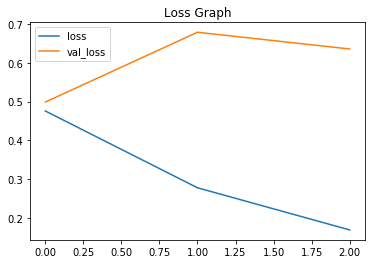

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

In [15]:
# 模型的 Layer List
model.layers

In [16]:
# 拿最初的 input 和第一層 (embedding) 的輸出拿來當新模型
from keras.models import Model
embedding_layer_model = Model(inputs=model.input,
outputs=model.layers[0].output)
# 把第一筆文章拿來給你看轉換後的維度
em = embedding_layer_model.predict(x_test_pad[0:1])
em

array([[[ 0.00541433, -0.08416983, -0.01922217, ...,  0.03900272,
         -0.0033809 ,  0.00592497],
        [-0.04753437, -0.01827802, -0.00915897, ...,  0.00155364,
          0.00873591, -0.00631222],
        [ 0.04155981,  0.02332471, -0.06105872, ...,  0.01193838,
          0.00481949,  0.0132358 ],
        ...,
        [-0.00386902,  0.11367245,  0.0268304 , ..., -0.00870964,
          0.05341789, -0.01612249],
        [-0.03906203, -0.04828183, -0.04230684, ...,  0.01735738,
          0.04750546,  0.03095474],
        [-0.01450262, -0.04928355, -0.06407021, ...,  0.00331672,
         -0.09210747,  0.0011226 ]]], dtype=float32)

In [17]:
print("維度:", em.shape)
print("第一個詞被轉換過的向量:\n", em[0][0])

維度: (1, 100, 32)
第一個詞被轉換過的向量: [ 0.00541433 -0.08416983 -0.01922217 -0.00924112 -0.01759168 -0.0195541
  0.03181692 -0.06140333 -0.02187323 -0.02526633  0.01290257  0.03515774
 -0.0281421   0.04525241 -0.05751041  0.00353973 -0.0330568  -0.00954974
 -0.02919315 -0.04643373  0.108855   -0.05129733 -0.10210039  0.09396663
  0.02256816 -0.01762328  0.06804785 -0.06041132  0.06774014  0.03900272
 -0.0033809   0.00592497]


In [18]:
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(output_dim=32, input_dim=2000, input_length=100))
model.add(Dropout(0.2))
# RNN: 記憶 16 個狀態
model.add(SimpleRNN(units=16))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.35))
# 注意一下, 因為我們是二元分類, 最後的激勵函數選擇 sigmoid
# sigmoid(正 + 負 =100%) softmax(類別全部 =100%)
model.add(Dense(units=1, activation='sigmoid'))
# 特別注意一下, 因為我們只是二元分類, 所以這裡的 loss 選擇 binary_crossentropy
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 69,393
Trainable params: 69,393
Non-trainable params: 0
__________________________________________________

In [19]:
train_history = model.fit(x_train_pad, y_train,
                          batch_size = 100,
                          epochs = 3,
                          verbose = 2,
                          validation_split = 0.2)
y_test = test_df['sentiment']
# 正確率是 list 第二個元素
model.evaluate(x_test_pad, y_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
 - 13s - loss: 0.5069 - acc: 0.7473 - val_loss: 0.5139 - val_acc: 0.7758
Epoch 2/3
 - 13s - loss: 0.3446 - acc: 0.8541 - val_loss: 0.4162 - val_acc: 0.8138
Epoch 3/3
 - 13s - loss: 0.2938 - acc: 0.8819 - val_loss: 0.4238 - val_acc: 0.8102
25000/25000 [==============================] - 26s 1ms/step


[0.3729605825138092, 0.83744]